# Compute lengths of sample in CV

¡ Think to look for both en-us only and all accents !

In [1]:
# autoreloads
%reload_ext autoreload
%autoreload 1
%aimport parameters

# Allows to load modules from parent directory
from time import time
import inspect, sys
from os.path import dirname, abspath
sys.path.append(dirname(dirname(abspath(inspect.getfile(inspect.currentframe())))))

from pathlib import Path
from os import makedirs

#from models.accent_classifier import AccentClassifier

from tqdm import tqdm_notebook as tqdm

from torch.nn.modules import CrossEntropyLoss
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_

import numpy as np
import pandas as pd

from data.data_loader import create_binarizer, get_accents_counts
from data.data_loader import SpectrogramAccentDataset, BucketingSampler, AudioDataLoader
from utils import count_parameters, Timer

import math

In [2]:
param = parameters.get_parameters(dev=False)
accent_binarizer = create_binarizer(param['train_manifest'])
labels = accent_binarizer.classes_

In [3]:
audio_conf = {'sample_rate': param['sample_rate'],
                'window_size': param['window_size'],
                'window_stride': param['window_stride'],
                'window': param['window'],
                'noise_dir': param['noise_dir'],
                'noise_prob': param['noise_prob'],
                'noise_levels': (param['noise_min'], param['noise_max'])}

In [4]:
test_dataset = SpectrogramAccentDataset(audio_conf=audio_conf, 
                                        manifest_filepath=param['train_manifest'], 
                                        labels=labels,
                                        normalize=True, 
                                        augment=False, 
                                        accent_binarizer=accent_binarizer,
                                        kaldi=False)

test_loader = AudioDataLoader(test_dataset,
                                num_workers=param['num_worker'], 
                                batch_size=param['batch_size'])

In [5]:
samples = []
for a in tqdm(test_loader, total=len(test_loader)):
    input_sizes = a[2].mul_(int(a[0].size(3))).int()       
    samples.extend(list(input_sizes))
samples = np.array(samples)

OSError: Traceback (most recent call last):
  File "/home/thibault/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/thibault/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/thibault/code/deepspeech.pytorch/data/data_loader.py", line 268, in __getitem__
    spect = self.parse_audio(audio_path)
  File "/home/thibault/code/deepspeech.pytorch/data/data_loader.py", line 116, in parse_audio
    y = load_audio(audio_path)
  File "/home/thibault/code/deepspeech.pytorch/data/data_loader.py", line 32, in load_audio
    sound, _ = torchaudio.load(path, normalization=True)
  File "/home/thibault/anaconda3/lib/python3.6/site-packages/torchaudio-0.1-py3.6-linux-x86_64.egg/torchaudio/__init__.py", line 48, in load
    raise OSError("{} not found or is a directory".format(filepath))
OSError: ../data/CommonVoice_dataset/cv-valid-train/wav/sample-000005.wav not found or is a directory


In [20]:
len(samples)

20000

In [21]:
samples.max()

999

In [22]:
int(samples.mean())

398

In [23]:
int(samples.std())

151

/home/thibault/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/thibault/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


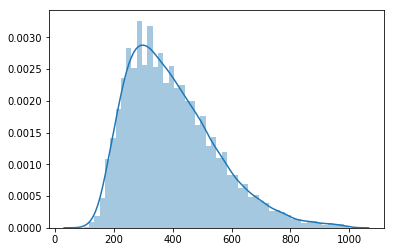

In [24]:
import seaborn as sns
sns.distplot(samples)

In [25]:
int(np.percentile(samples, 95))

689

In [10]:
# dev max 917, mean 393, std 149, 95th per 683

In [26]:
# train max 999, mean 398, std 151, 95th per 689

In [38]:
cnt = 0
for s in samples:
    if s <= 700:
        cnt += 1
cnt / len(samples) * 100

95.595